In [15]:
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sksurv.datasets import load_breast_cancer
from sksurv.linear_model import CoxPHSurvivalAnalysis, CoxnetSurvivalAnalysis
from sksurv.preprocessing import OneHotEncoder
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sksurv.datasets import load_breast_cancer
from sksurv.ensemble import ComponentwiseGradientBoostingSurvivalAnalysis
from sksurv.ensemble import GradientBoostingSurvivalAnalysis
import pickle
from datetime import datetime

cancers = ['BLCA', 'BRCA', 'HNSC', 'LAML', 'LGG', 'LUAD']
path_prefix = 'C:/Users/sharony/SurvivalAnalysis/'
if os.getlogin() =='meiry':
    path_prefix = 'D:/sharon/medical_genomics_data/'


train_portion = 0.85
test_portion = 0.15

In [16]:
def calc_time_to_event(x):
    #print(type(x) , x)
    assert x.vital_status in ['Dead', 'Alive']
    if x.vital_status=='Dead':
        try:
            assert isinstance(int(x.death_days_to), int)
        except:
            print(type(x.death_days_to), 'non int entry in x.death_days_to' , x.death_days_to, 'removing row',x.vital_status, x.death_days_to)        
            return None
        assert float(x.death_days_to) >= 0
        return int(x.death_days_to)
    try:
        assert isinstance(int(x.last_contact_days_to), int) 
    except :
        print(type(x.last_contact_days_to), 'non int entry in x.last_contact_days_to' , x.last_contact_days_to, 'removing row',x.vital_status, x.death_days_to)        
        return None
    if int(x.last_contact_days_to) < 0:
        print('negative entry in x.last_contact_days_to' , x.last_contact_days_to, 'fixing it')
    return abs(int(x.last_contact_days_to))


In [17]:
from datetime import datetime
print(datetime.now())

2020-12-12 22:42:20.578299


In [27]:
def boosting_model(ct, clinical_data, omics, comment):
    data = omics.copy()
    time_to_event = clinical_data.apply(calc_time_to_event, axis = 1).astype('int32').values
    event = (clinical_data['vital_status'].values == 'Dead')
    y_data = [ event,time_to_event]
    list_of_tuples = list(zip(event, time_to_event)) 
    df_y  = pd.DataFrame(list_of_tuples, columns = ['event', 'time_to_event'])
    #X_train, X_test, y_train, y_test = train_test_split(data, df_y, test_size = test_portion, random_state=42)
    y = df_y.to_numpy(copy=True)
    X = data.to_numpy()
    y2 = np.asarray([tuple(y[i,:]) for i in range(y.shape[0])],dtype=[('e.tdm', '?'), ('t.tdm', '<f8')])
    X_train, X_test, y_train, y_test = train_test_split(X, y2, test_size= test_portion , random_state=0)
    
    print("Boosting results for cancer type",ct,"with",comment,"omics:\n")
    
    max_range = 32
    min_range = 5
    scores_cph_tree = {}

    est_cph_tree = GradientBoostingSurvivalAnalysis(learning_rate=1.0, max_depth=1, random_state=0)
    

    n_estimators = [i * 5 for i in range(min_range, max_range)]

    estimators = {
        "no regularization": GradientBoostingSurvivalAnalysis(
            learning_rate=1.0, max_depth=1, random_state=0
        ),
        "learning rate": GradientBoostingSurvivalAnalysis(
            learning_rate=0.1, max_depth=1, random_state=0
        ),
        "dropout": GradientBoostingSurvivalAnalysis(
            learning_rate=1.0, dropout_rate=0.1, max_depth=1, random_state=0
        ),
        "subsample": GradientBoostingSurvivalAnalysis(
            learning_rate=1.0, subsample=0.5, max_depth=1, random_state=0
        ),
    }

    scores_reg = {k: [] for k in estimators.keys()}
    for n in n_estimators:
        for name, est in estimators.items():
            est.set_params(n_estimators=n)
            est.fit(X_train, y_train)
            cindex = est.score(X_test, y_test)
            scores_reg[name].append(cindex)

    scores_reg = pd.DataFrame(scores_reg, index=n_estimators)
    title = ct+ ' '+ comment+ ' omics ' + str(n_estimators)+ ' estimators'
    ax = scores_reg.plot(xlabel="n_estimators", ylabel="concordance index", title = title)
    ax.grid(True)
    print(scores_reg.to_string())

        


2020-12-13 22:16:28.467471 BLCA Entered
negative entry in x.last_contact_days_to -21 fixing it
negative entry in x.last_contact_days_to -64 fixing it
Boosting results for cancer type BLCA with merged omics:

     no regularization  learning rate   dropout  subsample
25            0.654378       0.649770  0.661290   0.580645
30            0.658986       0.665899  0.656682   0.518433
35            0.617512       0.665899  0.661290   0.481567
40            0.608295       0.679724  0.668203   0.523041
45            0.603687       0.679724  0.640553   0.495392
50            0.608295       0.675115  0.654378   0.474654
55            0.617512       0.677419  0.649770   0.534562
60            0.612903       0.668203  0.654378   0.548387
65            0.645161       0.663594  0.658986   0.562212
70            0.645161       0.654378  0.691244   0.543779
75            0.640553       0.654378  0.663594   0.539171
80            0.626728       0.654378  0.645161   0.543779
85            0.622120   

     no regularization  learning rate   dropout  subsample
25            0.617021       0.468085  0.414894   0.265957
30            0.617021       0.436170  0.414894   0.265957
35            0.617021       0.436170  0.393617   0.244681
40            0.627660       0.414894  0.393617   0.244681
45            0.627660       0.414894  0.393617   0.308511
50            0.712766       0.414894  0.393617   0.329787
55            0.712766       0.414894  0.393617   0.329787
60            0.680851       0.414894  0.393617   0.329787
65            0.680851       0.414894  0.393617   0.319149
70            0.680851       0.414894  0.393617   0.361702
75            0.680851       0.414894  0.393617   0.361702
80            0.680851       0.414894  0.393617   0.361702
85            0.680851       0.414894  0.393617   0.351064
90            0.659574       0.414894  0.393617   0.351064
95            0.659574       0.414894  0.393617   0.351064
100           0.691489       0.585106  0.393617   0.3085

     no regularization  learning rate   dropout  subsample
25            0.584726       0.525060  0.597852   0.622912
30            0.565632       0.565632  0.591885   0.551313
35            0.570406       0.590692  0.594272   0.556086
40            0.560859       0.585919  0.591885   0.618138
45            0.594272       0.597852  0.591885   0.610979
50            0.591885       0.597852  0.594272   0.572792
55            0.608592       0.608592  0.594272   0.577566
60            0.570406       0.610979  0.596659   0.615752
65            0.572792       0.618138  0.596659   0.632458
70            0.584726       0.618138  0.589499   0.625298
75            0.591885       0.615752  0.591885   0.637232
80            0.589499       0.615752  0.601432   0.620525
85            0.601432       0.613365  0.596659   0.637232
90            0.579952       0.613365  0.603819   0.644391
95            0.603819       0.610979  0.603819   0.639618
100           0.610979       0.608592  0.601432   0.6205

     no regularization  learning rate   dropout  subsample
25            0.699187       0.646341  0.634146   0.577236
30            0.650407       0.658537  0.666667   0.479675
35            0.658537       0.642276  0.658537   0.439024
40            0.626016       0.650407  0.642276   0.479675
45            0.617886       0.658537  0.642276   0.495935
50            0.666667       0.642276  0.634146   0.504065
55            0.650407       0.626016  0.634146   0.504065
60            0.658537       0.650407  0.658537   0.569106
65            0.650407       0.658537  0.658537   0.544715
70            0.658537       0.658537  0.658537   0.552846
75            0.658537       0.642276  0.642276   0.577236
80            0.658537       0.642276  0.642276   0.593496
85            0.650407       0.658537  0.666667   0.560976
90            0.650407       0.650407  0.650407   0.577236
95            0.666667       0.674797  0.658537   0.577236
100           0.666667       0.650407  0.658537   0.5853

c:\users\sharony\appdata\local\programs\python\python38\lib\site-packages\pandas\plotting\_matplotlib\core.py:328: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


     no regularization  learning rate   dropout  subsample
25            0.505208       0.546875  0.380208   0.723958
30            0.500000       0.557292  0.505208   0.677083
35            0.546875       0.588542  0.442708   0.666667
40            0.494792       0.468750  0.494792   0.750000
45            0.526042       0.489583  0.494792   0.734375
50            0.515625       0.531250  0.463542   0.734375
55            0.463542       0.541667  0.494792   0.708333
60            0.536458       0.520833  0.515625   0.718750
65            0.526042       0.500000  0.494792   0.718750
70            0.515625       0.500000  0.494792   0.723958
75            0.505208       0.520833  0.479167   0.692708
80            0.484375       0.510417  0.505208   0.671875
85            0.484375       0.510417  0.515625   0.671875
90            0.494792       0.510417  0.505208   0.656250
95            0.494792       0.484375  0.494792   0.656250
100           0.484375       0.484375  0.494792   0.6562

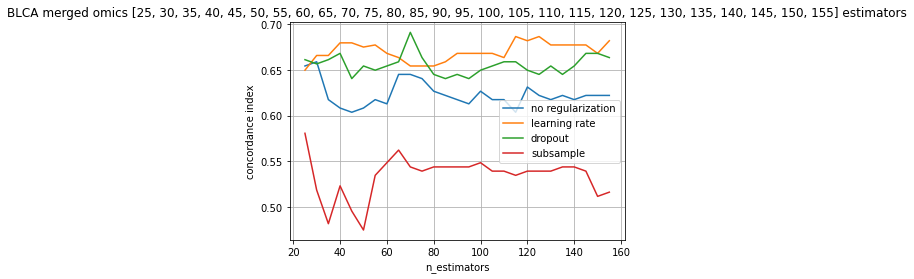

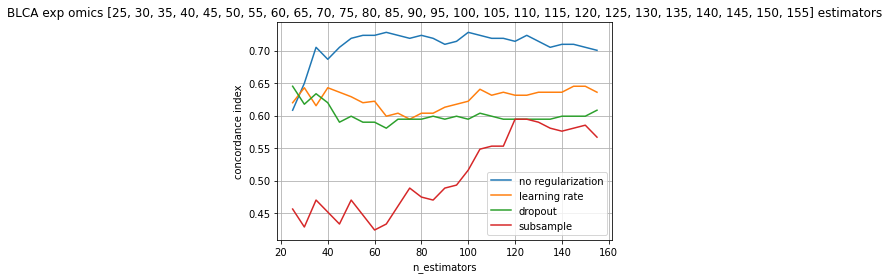

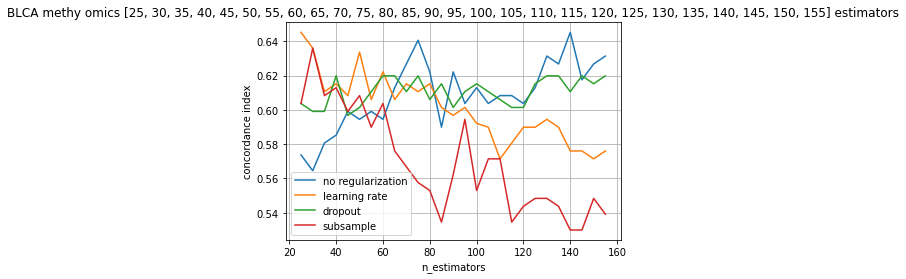

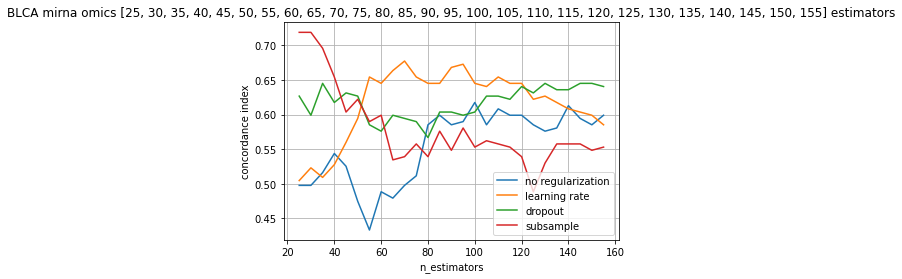

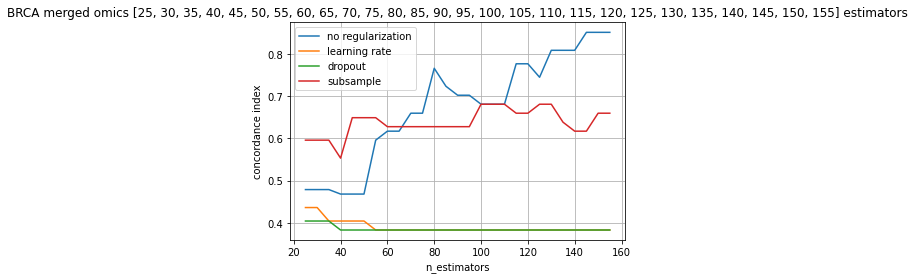

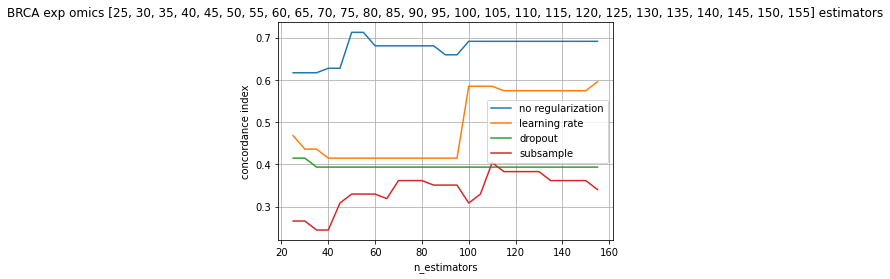

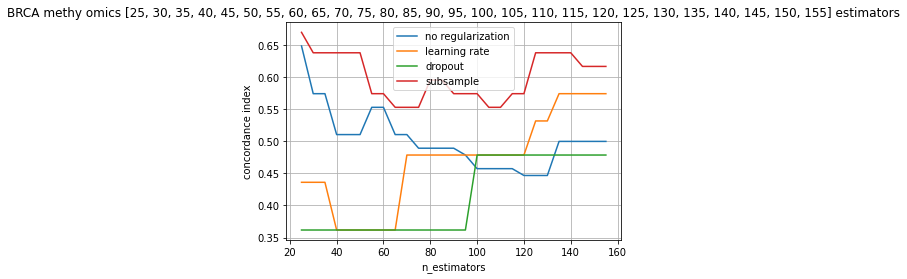

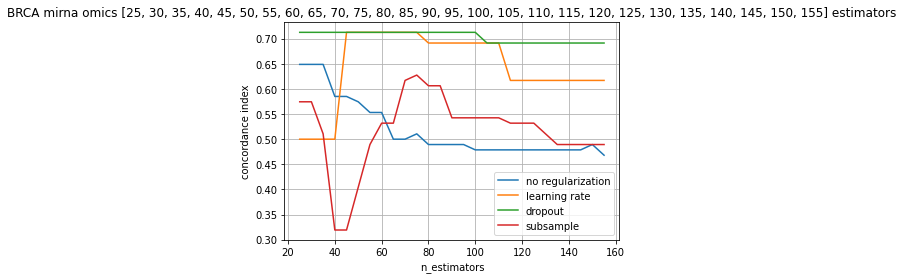

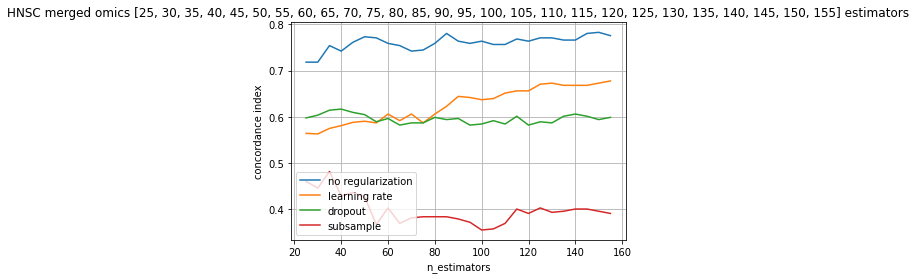

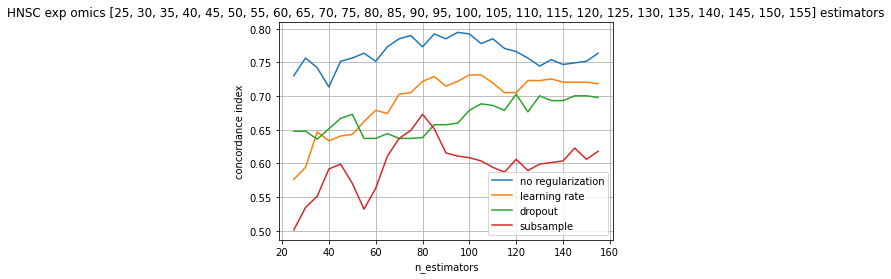

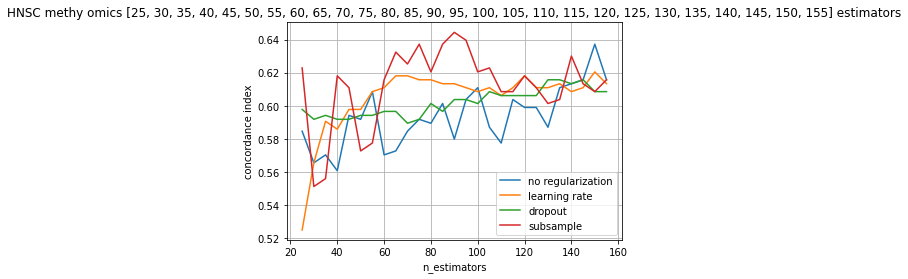

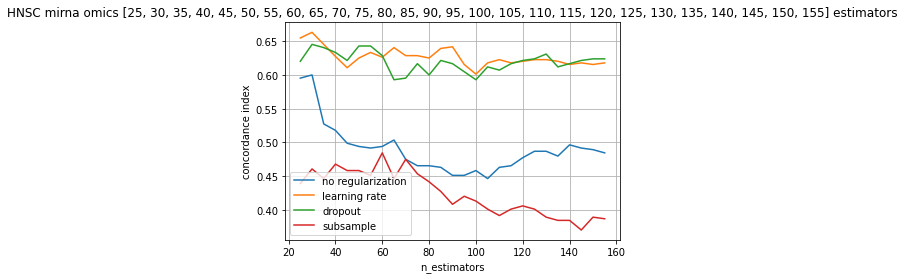

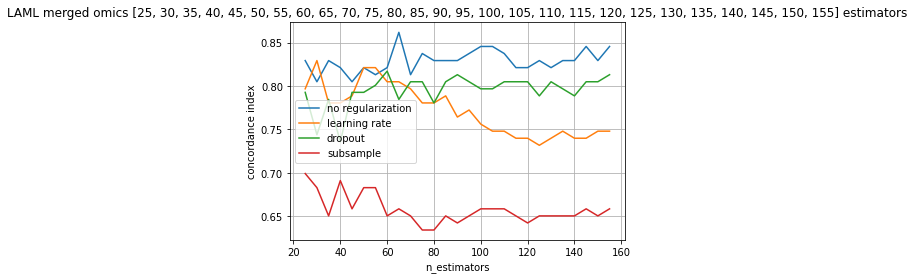

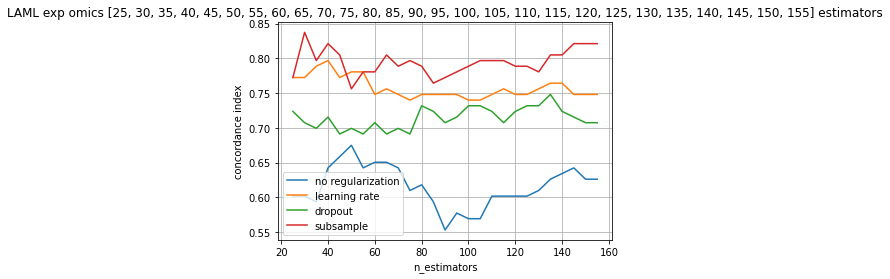

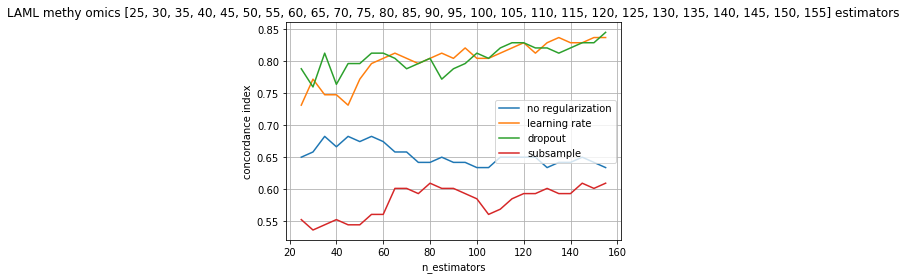

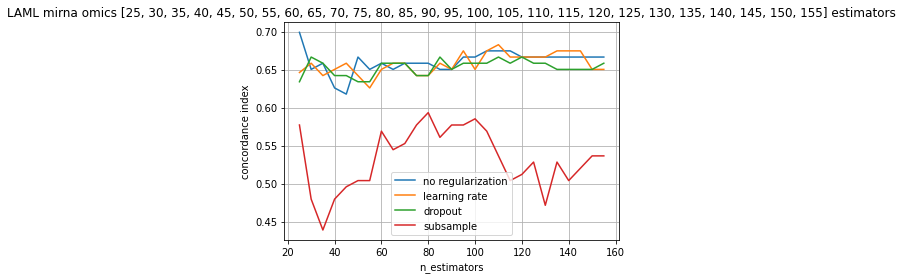

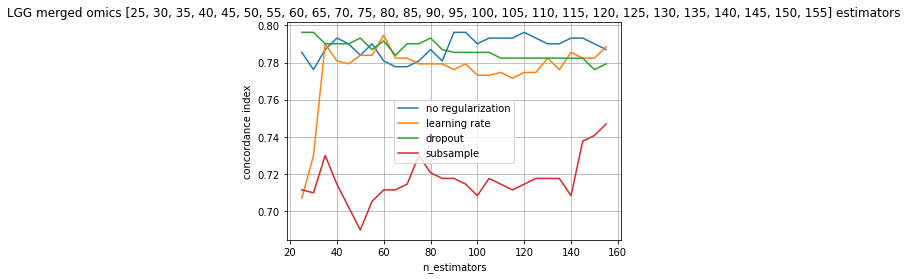

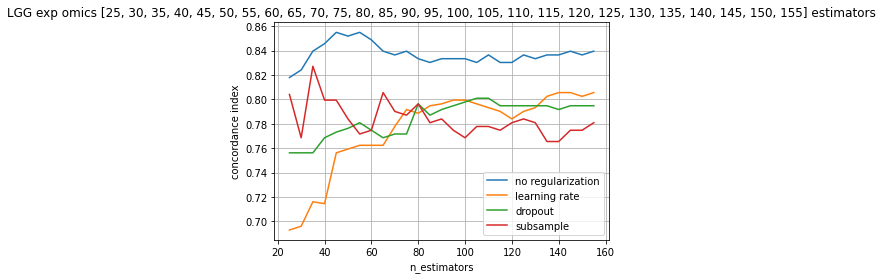

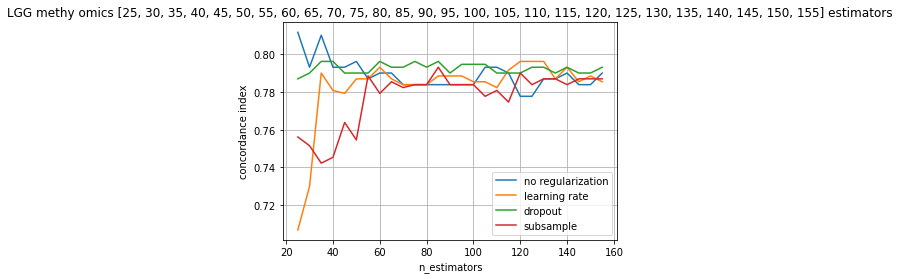

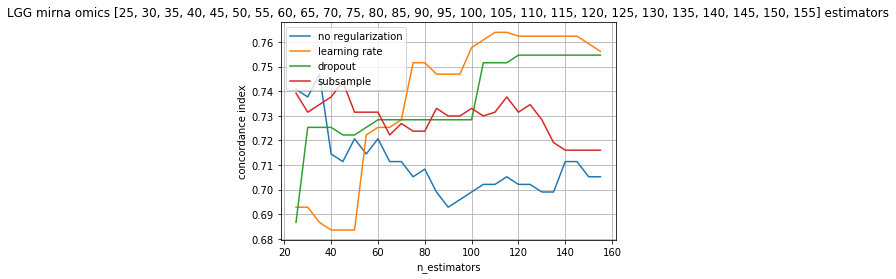

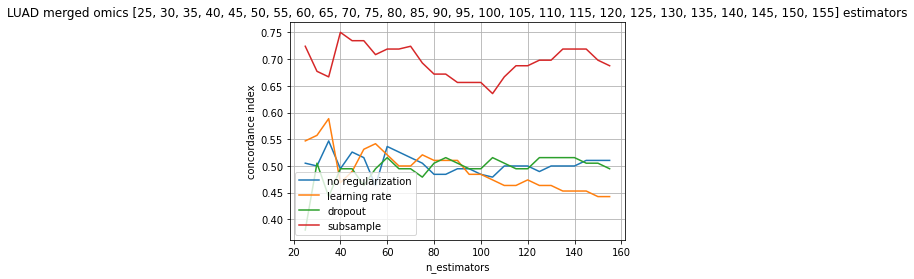

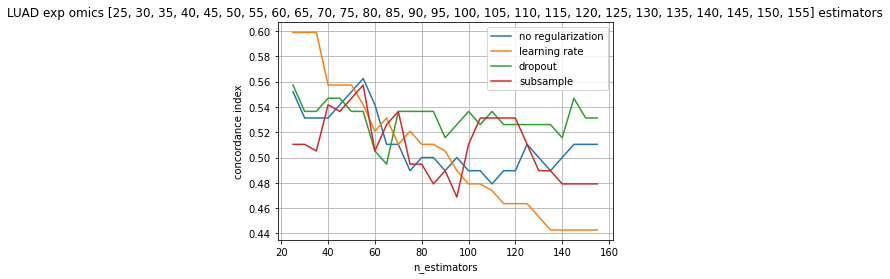

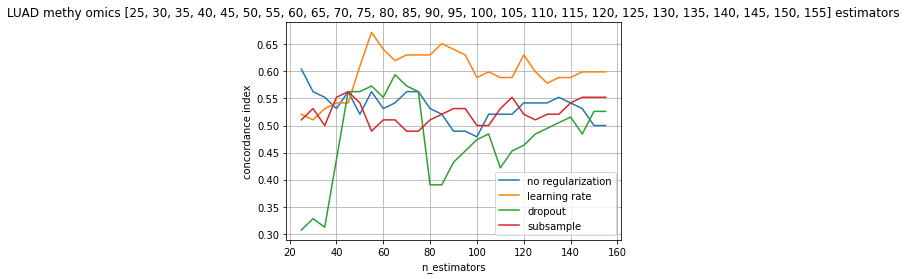

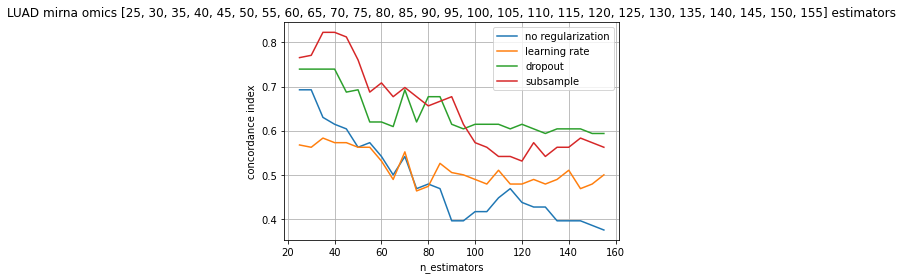

In [28]:
for ct in cancers:
    print(datetime.now(), ct, 'Entered')
    ct_path = f'{path_prefix}{ct}'
    if not os.path.exists(f'{ct}_clinical.pkl'):
        print(datetime.now(), ct, 'skipping because clinical data was not processed')
        continue
    clinical_data = pickle.load(open(f'{ct}_clinical.pkl', 'rb'))
    if not os.path.exists(f'{ct}_omics.pkl'):
        print(datetime.now(), 'Not found', 'merged', f'{ct}_omics.pkl')
    else:
        omics = pickle.load(open(f'{ct}_omics.pkl', 'rb'))
        boosting_model(ct, clinical_data, omics, 'merged')
        print(datetime.now())
    if not os.path.exists(f'{ct}_exp_omics.pkl'):
        print(datetime.now(), 'Not found', 'exp', f'{ct}_omics.pkl')
    else:
        exp = pickle.load(open(f'{ct}_exp_omics.pkl', 'rb'))
        boosting_model(ct, clinical_data, exp, 'exp')
        print(datetime.now())
    if not os.path.exists(f'{ct}_methy_omics.pkl'):
        print(datetime.now(), 'Not found', 'methy', f'{ct}_methy_omics.pkl')
    else:
        methy = pickle.load(open(f'{ct}_methy_omics.pkl', 'rb'))
        boosting_model(ct, clinical_data, methy, 'methy')
        print(datetime.now())
    if not os.path.exists(f'{ct}_mirna_omics.pkl'):
        print(datetime.now(), 'Not found', 'mirna', f'{ct}_mirna_omics.pkl')
    else:
        mirna = pickle.load(open(f'{ct}_mirna_omics.pkl', 'rb'))
        boosting_model(ct, clinical_data, mirna, 'mirna')
        print(datetime.now())
    print()
    print(datetime.now(), ct, 'DONE')
    print()


In [23]:
clinical_data = pickle.load(open('BRCA_clinical.pkl', 'rb'))
omics = pickle.load(open('BRCA_omics.pkl', 'rb'))

negative entry in x.last_contact_days_to -7 fixing it
Boosting results for cancer type ct with comment omics:

   no regularization  learning rate   dropout  subsample
5           0.404255            0.5  0.468085   0.468085


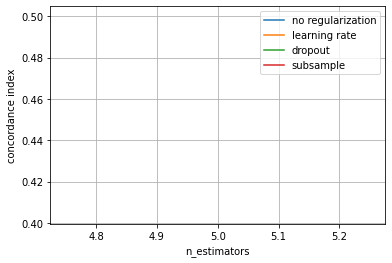

In [11]:

boosting_model('ct', clinical_data, omics, 'comment')

In [20]:
# max_range = 32
# min_range = 15
# scores_cph_tree = {}

# est_cph_tree = GradientBoostingSurvivalAnalysis(
#     learning_rate=1.0, max_depth=1, random_state=0
# )
# for i in range(min_range, max_range):
#     n_estimators = i * 5
#     est_cph_tree.set_params(n_estimators=n_estimators)
#     est_cph_tree.fit(X_train, y_train)
#     scores_cph_tree[n_estimators] = est_cph_tree.score(X_test, y_test)

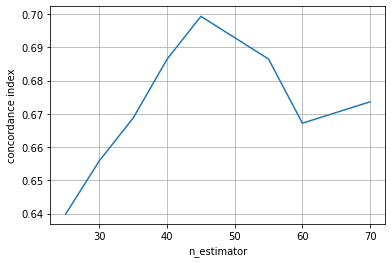

In [21]:
# x, y = zip(*scores_cph_tree.items())
# plt.plot(x, y)
# plt.xlabel("n_estimator")
# plt.ylabel("concordance index")
# plt.grid(True)

In [3]:
# max_range = 15
# min_range = 5
# n_estimators = [i * 5 for i in range(min_range, max_range)]

# estimators = {
#     "no regularization": GradientBoostingSurvivalAnalysis(
#         learning_rate=1.0, max_depth=1, random_state=0
#     ),
#     "learning rate": GradientBoostingSurvivalAnalysis(
#         learning_rate=0.1, max_depth=1, random_state=0
#     ),
#     "dropout": GradientBoostingSurvivalAnalysis(
#         learning_rate=1.0, dropout_rate=0.1, max_depth=1, random_state=0
#     ),
#     "subsample": GradientBoostingSurvivalAnalysis(
#         learning_rate=1.0, subsample=0.5, max_depth=1, random_state=0
#     ),
# }

# scores_reg = {k: [] for k in estimators.keys()}
# for n in n_estimators:
#     for name, est in estimators.items():
#         est.set_params(n_estimators=n)
#         est.fit(X_train, y_train)
#         cindex = est.score(X_test, y_test)
#         scores_reg[name].append(cindex)

# scores_reg = pd.DataFrame(scores_reg, index=n_estimators)

NameError: name 'GradientBoostingSurvivalAnalysis' is not defined

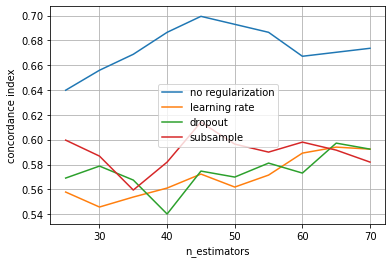

In [32]:
# ax = scores_reg.plot(xlabel="n_estimators", ylabel="concordance index")
# ax.grid(True)

In [33]:
# scores_reg

,no regularization,learning rate,dropout,subsample
25,0.639871,0.557878,0.569132,0.599678
30,0.655949,0.545820,0.578778,0.586817
35,0.668810,0.553859,0.567524,0.559486
40,0.686495,0.561093,0.540193,0.581994
45,0.699357,0.572347,0.574759,0.614148
50,0.692926,0.561897,0.569936,0.596463
55,0.686495,0.571543,0.581190,0.590032
60,0.667203,0.589228,0.573151,0.598071
65,0.670418,0.594051,0.597267,0.591640
70,0.673633,0.592444,0.592444,0.581994
